<h1 style="color:red; text-align:center; text-decoration:underline;">Réseaux LSTM pour la Prédiction de Séries Temporelles</h1>


# LSTM

## Imports

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

## Loading data

In [22]:
train = pd.read_csv(r'C:\Users\Lenovo Thinkpad X1\Downloads\A_Jupyter__Algo__DL\Deep Learning\LSTM Data\DailyDelhiClimateTrain.csv')
test = pd.read_csv(r'C:\Users\Lenovo Thinkpad X1\Downloads\A_Jupyter__Algo__DL\Deep Learning\LSTM Data\DailyDelhiClimateTest.csv')


In [23]:
print(f"train_shape: {train.shape}")
print(f"test_shape: {test.shape}")

train_shape: (1462, 5)
test_shape: (114, 5)


## Preprocessing

In [24]:
WINDOW_SIZE = 5

In [25]:
def data_to_input_and_output(data):

    input_data = []
    output_data = []
    for index in range(0, len(data) - WINDOW_SIZE):
        input_sample = data['meantemp'][index:index + WINDOW_SIZE]
        output_sample = data['meantemp'][index + WINDOW_SIZE]

        input_data.append(input_sample)
        output_data.append(output_sample)

    return np.array(input_data), np.array(output_data)

In [26]:
train_input, train_output = data_to_input_and_output(train)
test_input, test_output = data_to_input_and_output(test)

## Building and traing the neural network

In [29]:
def train_neural_network(X, y, epochs=7, learning_rate=0.005):

    model = Sequential()
    model.add(InputLayer((WINDOW_SIZE, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    check_point = ModelCheckpoint('model/best_model.keras', save_best_only=True, monitor='loss')
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])

    model.fit(X, y, epochs=epochs, callbacks=[check_point])
    return model

In [30]:
model = train_neural_network(train_input, train_output)

Epoch 1/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 486.4410 - root_mean_squared_error: 21.9033
Epoch 2/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.3752 - root_mean_squared_error: 7.5011
Epoch 3/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.5742 - root_mean_squared_error: 4.6806
Epoch 4/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3159 - root_mean_squared_error: 2.0770
Epoch 5/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4393 - root_mean_squared_error: 1.8539
Epoch 6/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1670 - root_mean_squared_error: 1.7789
Epoch 7/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9882 - root_mean_squared_error: 1.7281


## Predictions

In [32]:
model = load_model('model/best_model.keras')

In [33]:
train_pred = model.predict(train_input)
test_pred = model.predict(test_input)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [35]:
def plot_predictions(pred, y_true, label, period):
    # Convert period to datetime if it's not already
    period = pd.to_datetime(period)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(period, y_true, label='True Values', marker='o', color='black')
    plt.plot(period, pred, label='Predictions', marker='o', color='red')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Mean temperature')
    plt.title(label)

    # Adding legend
    plt.legend()

    if label == "Train Data":
        # Format X-axis to show only years
        plt.gca().xaxis.set_major_locator(YearLocator())
        plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    elif label == "Test Data":
        # Format X-axis to show only months
        plt.gca().xaxis.set_major_locator(MonthLocator())
        plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

    # Rotate x-axis labels for better visibility
    plt.gcf().autofmt_xdate()

    # Show the plot
    plt.show()

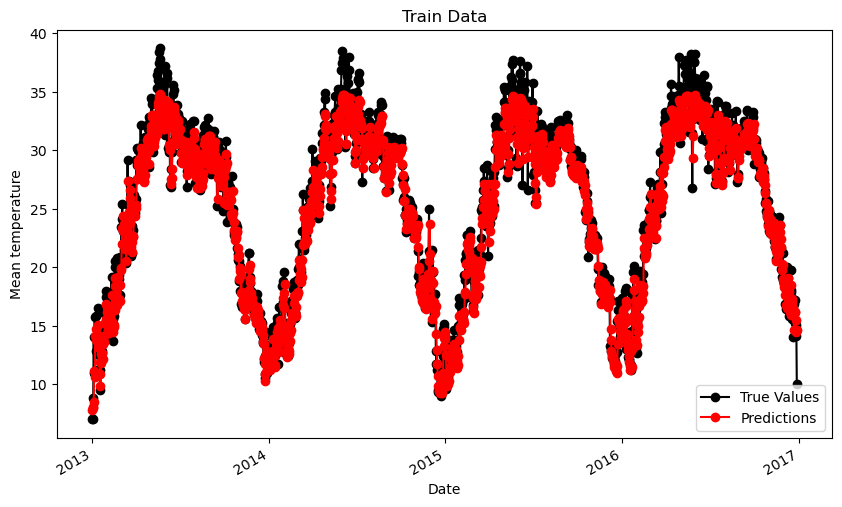

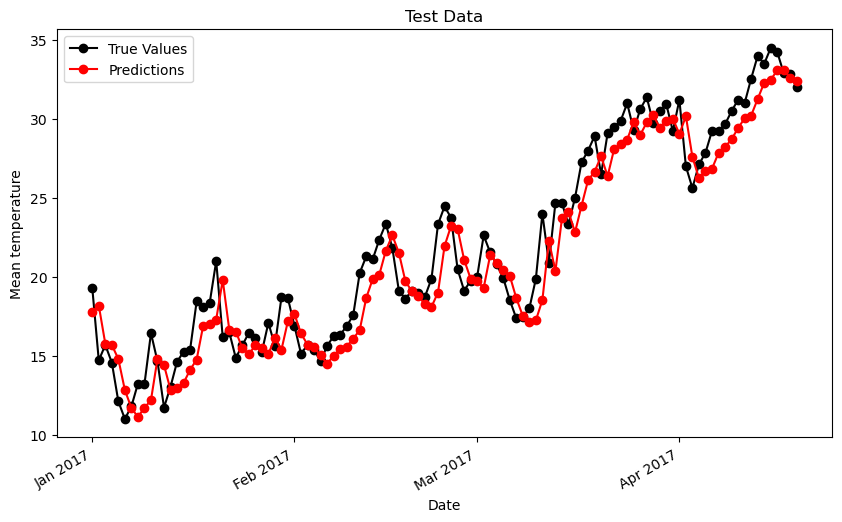

In [36]:
train_period = train[0:len(train) - WINDOW_SIZE]['date']
test_period = test[0:len(test) - WINDOW_SIZE]['date']

plot_predictions(train_pred, train_output, 'Train Data', train_period)
plot_predictions(test_pred, test_output, 'Test Data', test_period)

## How to predict the future?

In [37]:
predictions = []

def predict_the_future(input_seq, period_prediction: int = 7):
    if period_prediction == 0:
        return None
    new_prediction = model.predict(input_seq)
    predictions.append(new_prediction[0][0])

    # input_seq = [[0], [1], [2], [3], [4]]
    # prediction = [5]
    # --> new_seq = [[1], [2], [3], [4], [5]]
    new_seq = np.array([np.concatenate((input_seq[0][1:WINDOW_SIZE], new_prediction[0]))])
    
    predict_the_future(new_seq, period_prediction - 1)

In [38]:
seq_start = np.array([[15, 15.5, 16, 17, 18]])

if len(seq_start[0]) != WINDOW_SIZE:
    raise "Size mismatch"
predict_the_future(seq_start)

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[16.842262, 16.311802, 16.043251, 15.838387, 15.465373, 15.168582, 14.910904]

<h3 style="color:#0056b3; text-decoration:underline;">Résultat et Interprétation</h3>

Dans ce projet, un réseau LSTM a été utilisé pour modéliser une série temporelle représentant les températures journalières moyennes à Delhi.  
Grâce à sa capacité à capturer les dépendances à long terme, le modèle a appris à prédire la température du jour suivant à partir des cinq jours précédents (fenêtre glissante).

L’entraînement sur les données historiques a permis une convergence progressive, comme le montre la diminution de l’erreur dans la courbe d’apprentissage.  
Les prédictions réalisées affichent une forte corrélation avec les données réelles, ce qui confirme l’efficacité du LSTM pour la prévision climatique à court terme.  
Ce modèle est également généralisable à d’autres domaines : prévision énergétique, analyse financière, ou maintenance prédictive.
